# Preprocessing

## The dataset

In [ ]:
import pandas as pd

data = pd.read_csv("../CSVs Cleaned/Cleaned Mobiles Dataset (2025).csv")
print(data.head())
y = data['price']

  Company Name  Mobile Weight  RAM   Processor  Battery Capacity  Screen Size  \
0        Apple          174.0  6.0  A17 Bionic              3600          6.1   
1        Apple          174.0  6.0  A17 Bionic              3600          6.1   
2        Apple          174.0  6.0  A17 Bionic              3600          6.1   
3        Apple          203.0  6.0  A17 Bionic              4200          6.7   
4        Apple          203.0  6.0  A17 Bionic              4200          6.7   

   Launched Year  Back Camera 1  Back Camera 2  Back Camera 3  Back Camera 4  \
0           2024             48              0              0              0   
1           2024             48              0              0              0   
2           2024             48              0              0              0   
3           2024             48              0              0              0   
4           2024             48              0              0              0   

   Front Camera 1  Front Camera 

Using TargetEncoder to encode categorical features

In [ ]:
from sklearn.preprocessing import TargetEncoder
from datetime import datetime
encoder = TargetEncoder(target_type="continuous")
data['Company Name_encoded'] = encoder.fit_transform(data[['Company Name']], y)
data['Processor_encoded'] = encoder.fit_transform(data[['Processor']], y)

del data['Company Name']
del data['Processor']

print(data.head())

   Mobile Weight  RAM  Battery Capacity  Screen Size  Launched Year  \
0          174.0  6.0              3600          6.1           2024   
1          174.0  6.0              3600          6.1           2024   
2          174.0  6.0              3600          6.1           2024   
3          203.0  6.0              4200          6.7           2024   
4          203.0  6.0              4200          6.7           2024   

   Back Camera 1  Back Camera 2  Back Camera 3  Back Camera 4  Front Camera 1  \
0             48              0              0              0              12   
1             48              0              0              0              12   
2             48              0              0              0              12   
3             48              0              0              0              12   
4             48              0              0              0              12   

   Front Camera 2  Storage  price  Company Name_encoded  Processor_encoded  
0        

Drop samples with empty columns and separate features from target feature, price. Then select the top 10 features based on their mutual information (nat) score.

In [ ]:
from sklearn.feature_selection import mutual_info_regression, SelectKBest
data = data.dropna()

y = data['price']
# dollars = []
# for price in y:
#     dollars.append(int(price) / 100)
# y = pd.DataFrame(dollars)
X = data.drop('price', axis=1)

mutual_info = mutual_info_regression(X, y)

# Create a DataFrame for better visualization
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': mutual_info,
}).sort_values(by='Score', ascending=False)

# Display the feature importance scores
print(feature_scores)

select = SelectKBest(mutual_info_regression, k=10).fit(X, y)
X = select.transform(X)
print(f"\nSelected Features: {select.get_feature_names_out()}")

                 Feature     Score
13     Processor_encoded  0.870488
9         Front Camera 1  0.483761
6          Back Camera 2  0.401838
3            Screen Size  0.371440
2       Battery Capacity  0.349115
12  Company Name_encoded  0.344625
11               Storage  0.319329
1                    RAM  0.313406
5          Back Camera 1  0.300819
0          Mobile Weight  0.279756
7          Back Camera 3  0.130617
8          Back Camera 4  0.008006
4          Launched Year  0.006641
10        Front Camera 2  0.005874

Selected Features: ['Mobile Weight' 'RAM' 'Battery Capacity' 'Screen Size' 'Back Camera 1'
 'Back Camera 2' 'Front Camera 1' 'Storage' 'Company Name_encoded'
 'Processor_encoded']


# Training and testing

Scaling features

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
scaled_X = sc_X.fit_transform(X)
scaled_y = sc_y.fit_transform(y.to_numpy().reshape(-1, 1))

Split the dataset into test data and training data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_X, scaled_y, test_size=0.4)

Fit the training data to the model, and test by performing predictions on the test data

In [ ]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X_train, y_train)

pred = regressor.predict(X_test)
pred = pd.DataFrame(pred)

# Revert scaled values to price information
predicted_price = sc_y.inverse_transform(pred)
real_price = sc_y.inverse_transform(y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Summarize performance

Train accuracy: 0.9033069739668363
Test accuracy: 0.8814139993867975
MAE: $81.35681836698623
MAPE: 0.17419216846003277


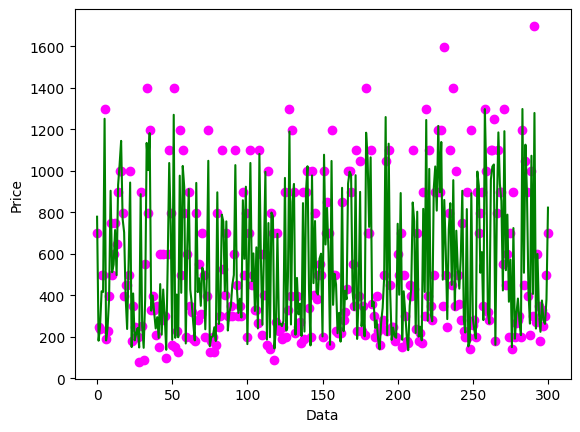

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

print(f"Train accuracy: {regressor.score(X_train, y_train)}")
print(f"Test accuracy: {regressor.score(X_test, y_test)}")
print(f"MAE: ${mean_absolute_error(real_price, predicted_price)}")
print(f"MAPE: {mean_absolute_percentage_error(real_price, predicted_price)}")

import matplotlib.pyplot as plt
graph_points = len(y_test)
plt.scatter(range(graph_points), real_price[:graph_points], color = 'magenta')
plt.plot(range(graph_points), predicted_price[:graph_points], color = 'green')
plt.xlabel('Data')
plt.ylabel('Price')
plt.show()

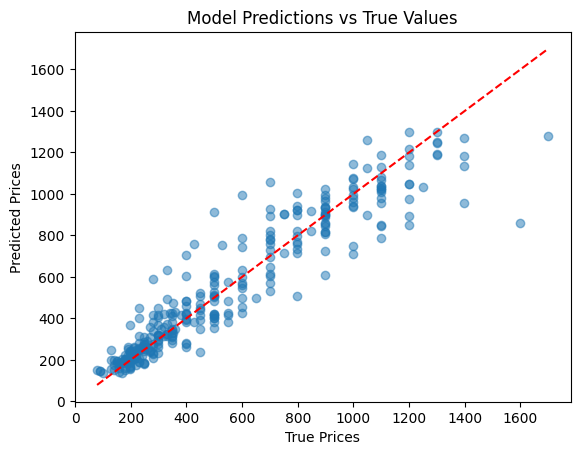

In [ ]:
plt.scatter(real_price, predicted_price, alpha=0.5)
plt.plot([min(real_price), max(real_price)], [min(real_price), max(real_price)], 'r--')
plt.xlabel("True Prices")
plt.ylabel("Predicted Prices")
plt.title("Model Predictions vs True Values")
plt.show()